# Correlation MIMIC IV


In [1]:
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import missingno as msno

In [2]:
path = '~/Documents/data/ts/miiv/fully_observed/miiv_ts_wide.parquet'
df = pd.read_parquet(path=path)
# path = '~/Documents/data/miiv/miiv_ts_eav.csv.gz'
# df = pd.read_csv(path)
# df = df.rename(columns={'stay_id':'id'})
print(df.shape)
df.tail()

(3552209, 51)


,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
3552204,39999810,4 days 13:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.0,140.0,NaN,NaN,NaN,NaN
3552205,39999810,4 days 14:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3552206,39999810,4 days 15:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17.0,128.0,NaN,NaN,NaN,NaN
3552207,39999810,4 days 16:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN
3552208,39999810,4 days 17:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Previous Correlation plot visualization (deprecated)

In [3]:
# df.to_csv('~/Documents/data/miiv/miiv_ts_wide.csv.gz', compression='infer', index=False)
df.to_parquet('~/Documents/data/miiv/miiv_ts_wide.parquet', index=False)

Text(0.5, 1.0, 'Pearson Correlation Matrix: Values of variables')

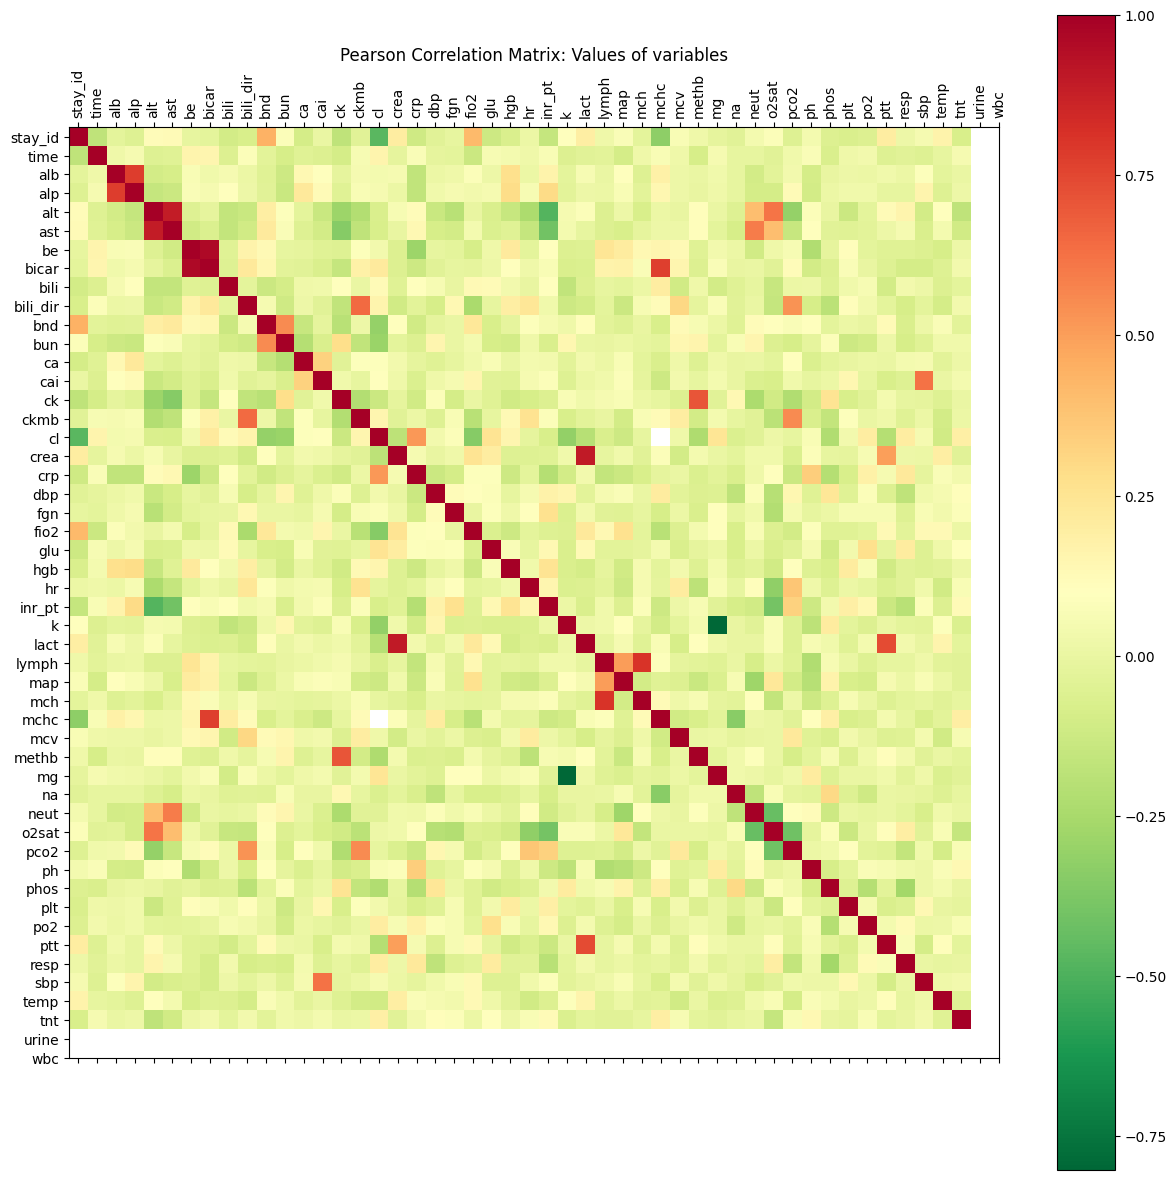

In [207]:
corr = df[df.columns[2:]].corr(method='pearson')
columns = df.columns
fig = plt.figure(figsize=(15,15))
matshow = plt.matshow(corr, fignum=False, cmap='RdYlGn_r') #xticklabels=corr.columns, yticklabels=corr.columns)

plt.xticks(np.arange(len(columns)), columns, rotation=90)
plt.yticks(np.arange(len(columns)), columns, rotation=00)
# plt.xlim(0, len(columns))
# plt.ylim(0, len(columns))

plt.colorbar(matshow)
plt.title('Pearson Correlation Matrix: Values of variables')

---
# Pearson Correlation for Dynamic Data

How to cite the Pearson correlation?

> Using this Link http://citebay.com/how-to-cite/pearson-correlation/ there is a statistics book that explains the topic and is suitable for citing.  
> Also has the bibtex format.  
>
> Freedman, D., Pisani, R., & Purves, R. (2007). Statistics (international student edition). Pisani, R. Purves, 4th Edn. WW Norton &amp; Company, New York.  

The correlation matrix can have `Nan` values for a correlation between two variables. There are two possible reasons for this:  
1. There is no datapoint containing values for the two variables in the dataset. Hence, no correlation could be calculated.
2. There might be some datapoints, where both variables contain values, but for at least one variable the variance is zero. This leads to `Nan` as a result, because the formula calculating the correlation contains the variances as denominators.

In the cases where the computation of the correlation value fails, the corresponding cell in the graph is marked with the symbol $\times$ .

In [1]:
# corr = df[df.columns[2:]].corr(method='pearson')
# df_missingness_indicator = ~df[df.columns[2:]].isna()*1
# corr_miss = df_missingness_indicator.corr(method='pearson')


In [3]:
def create_correlation_plot(corr: pd.DataFrame, corr_miss: pd.DataFrame, figsize=(15,15), path=None, large=True, colorbars=True):
    assert(corr.shape == corr_miss.shape), "Correlation and missingness correlation matrices must have the same shape. Given shapes were {} and {}.".format(corr.shape, corr_miss.shape)
    columns = corr.columns
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(17, 15)
    if large:
        ax = fig.add_subplot(gs[:15,:])
    else:
        ax = fig.add_subplot(gs[:13,:])
        
    # ax = plt.gca()

    """ ##########     VALUE  CORRELATION   #############"""
    corr1 = corr.copy()
    corr1[np.tril(corr, k=-1) == 0] = np.nan
    # split data into x and y so we can use scatter plot
    corr1 = pd.melt(corr1.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr1.columns = ['x', 'y', 'value']
    x=corr1['x']
    y=corr1['y']
    color1 = corr1['value']
    size=corr1['value'].abs()
    size /= size.max()

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    size_scale = 200
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange", 'darkred'])
    cmap1 = 'PiYG'
    # sc1 = ax.scatter(
    #     x=x.map(x_to_num)+0.5, # Use mapping for x
    #     y=y.map(y_to_num)+0.5, # Use mapping for y
    #     s= np.sqrt(size)* size_scale, # Vector of square sizes, proportional to size parameter
    #     marker='o', # Use circle as scatterplot marker
    #     c=color1, edgecolor='k', linewidth=0.5, cmap=cmap1, vmax=1, vmin=-1,
    # )
    
    I, J  = corr.shape
    corr_list = [(i, j, corr.iloc[i,j]) for i in range(I) for j in range(J) if i>j]
    corr_list = np.array(corr_list)
    # sizes = np.abs(corr_list[:,2])
    sizes = np.abs(corr_list[:,2])
    sizes /= np.nanmax(sizes)
    sc1 = ax.scatter(
        x=corr_list[:,0] + 0.5,
        y=corr_list[:,1] + 0.5,
        s=sizes * size_scale,
        c=corr_list[:,2], edgecolor='k', linewidth=0.5, cmap=cmap1, vmax=1, vmin=-1,
    )

    # add crosses, where there is missing data
    nan_args = np.argwhere(corr.isna().to_numpy())
    if len(nan_args) != 0:
        nan_args = np.array([(x,y) for (x,y) in list(nan_args) if x>y]) + 0.5
        ax.scatter(x=nan_args[:,0], y=nan_args[:,1], marker='x', c='black', s=200, lw=0.5)

    """ ##########  MISSINGNESS CORRELATION #############"""
    # # only show lower triangle
    # corr2 = corr_miss.copy()
    # corr2[np.triu(corr2, k=1) == 0] = np.nan

    # print(corr2.min().min(), corr2.max().max())
    # # split data into x and y so we can use scatter plot
    # corr2 = pd.melt(corr2.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    # corr2.columns = ['x', 'y', 'value']
    # x=corr2['x']
    # y=corr2['y']
    # color2 = corr2['value']
    # size=corr2['value'].abs()
    # size /= size.max()

    # # Mapping from column names to integer coordinates
    # x_labels = [v for v in sorted(x.unique())]
    # y_labels = [v for v in sorted(y.unique())]
    # x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    # y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    # size_scale = 200
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, '#1e7898'), (0.2, "#f6f7f7"), (0.6,"#e58368"), (1,'#700320')])
    # sc2 = ax.scatter(
    #     x=x.map(x_to_num)+0.5, # Use mapping for x
    #     y=y.map(y_to_num)+0.5, # Use mapping for y
    #     s= np.sqrt(size)* size_scale, # Vector of square sizes, proportional to size parameter
    #     marker='o', # Use square as scatterplot marker
    #     c=color2, edgecolor='k', linewidth=0.5, cmap=cmap2, vmax=1, vmin=-1,
    # )
    
    I, J  = corr_miss.shape
    corr_list = [(i, j, corr_miss.iloc[i,j]) for i in range(I) for j in range(J) if j>i]
    corr_list = np.array(corr_list)
    # sizes = np.abs(corr_list[:,2])
    sizes = np.abs(corr_list[:,2])
    sizes /= np.nanmax(sizes)
    sc2 = ax.scatter(
        x=corr_list[:,0] + 0.5, # Use mapping for x
        y=corr_list[:,1] + 0.5, # Use mapping for y
        s=sizes * size_scale, # Vector of square sizes, proportional to size parameter
        marker='o', # Use square as scatterplot marker
        c=corr_list[:,2], edgecolor='k', linewidth=0.5, cmap=cmap2, vmax=1, vmin=-0.25,
    )
    
    # add crosses, where there is missing data or no correlation data
    nan_args = np.argwhere(corr_miss.isna().to_numpy())
    if len(nan_args) != 0:
        nan_args = np.array([(y,x) for (x,y) in list(nan_args) if y<x]) + 0.5
        ax.scatter(x=nan_args[:,0], y=nan_args[:,1], marker='x', c='black', s=200, lw=0.5)


    """  #####  B A C K G R O U N D  &  D E S I G N  ######  """
    # diagonal line
    points =  [(0, len(columns)), (0, len(columns))]  # ((x1, x2), (y1,y2))
    plt.plot(points[0], points[1], color='black', lw=2, ls='-')

    # plot polygon (triangle), background color top right
    points =  [(0, len(columns), 0), (0, len(columns), len(columns))]  # ((x1, x2, x3), (y1,y2, y3))
    Points = np.array([[0,0], [len(columns),len(columns)], [len(columns), 0]])
    t1 = plt.Polygon(Points, color='azure', zorder=0)
    plt.gca().add_patch(t1)

    # background color bottom left
    ax.set_facecolor('lavenderblush')

    # grid & axis
    ax.set_ylim(len(columns), 0)
    ax.set_xlim(0, len(columns))
    ax.set_xticks(np.arange(0.5, len(columns)))
    ax.set_yticks(np.arange(0.5, len(columns)))
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xticklabels(columns, rotation=90)
    ax.set_yticklabels(columns, rotation=00)
    ax.tick_params(labelbottom=True, labeltop=True, labelright=True, bottom=True, top=False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.grid(False, 'major')
    ax.grid(True, 'minor', color='w')
    # spines
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)

    # colorbars in their own subplots
    if colorbars:
        # value correlation
        if large:
            ax = fig.add_subplot(gs[15:16,7:-1])
        else:
            ax = fig.add_subplot(gs[13:17,7:])
        resolution=100
        x = np.linspace(-1,1,resolution)
        X = np.repeat(x[np.newaxis, :], 1, axis=1)
        ax.pcolormesh(X, cmap=cmap1, vmin=-1, vmax=1)
        ax.tick_params(labelbottom=True, labeltop=False, bottom=True, top=True, right=False, labelright=False, labelleft=False, left=False)
        ax.xaxis.set_label_position("bottom")
        ax.set_xlabel('Value correlation')
        num_ticks = 5
        ax.set_xticks(np.linspace(0,1,num_ticks)*resolution)
        ax.set_xticklabels(np.linspace(-1, 1, num_ticks))
        # spines
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
        
        # colorbar missingness correlation
        if large:
            ax = fig.add_subplot(gs[15:16,1:6])
        else:
            ax = fig.add_subplot(gs[15:17,0:6])
        resolution=100
        x = np.linspace(-1,1,resolution)
        X = np.repeat(x[np.newaxis, :], 1, axis=1)
        ax.pcolormesh(X, cmap=cmap2)
        ax.tick_params(labelbottom=True, labeltop=False, bottom=True, top=True, right=False, labelright=False, labelleft=False, left=False)
        ax.xaxis.set_label_position("bottom")
        ax.set_xlabel('Missingness correlation')
        num_ticks = 6
        ax.set_xticks(np.linspace(0,1,num_ticks)*resolution*1)
        ax.set_xticklabels(np.linspace(-0.25, 1, num_ticks))
        # spines
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)

    plt.tight_layout()
    
    if path is not None:
        plt.savefig(path, bbox_inches='tight', transparent=True, format='pdf')
    plt.show()
    return 

In [4]:
df_with_time = df.copy()
df_with_time['time'] = df_with_time['time'].apply(lambda x: x.total_seconds() / 60 / 60)
corr = df_with_time[df.columns[:]].corr(method='pearson')
df_missingness_indicator = ~df_with_time[df.columns[:]].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')
print(f'Num variables: {len(df.columns)}')
print(f'corr.shape: {corr.shape}')
print(f'corr_miss.shape: {corr_miss.shape}')
print(f'Variabes that are unique to corr: {set(corr.columns) - set(corr_miss.columns)} <- ideally none')
print(f'Variabes that are unique to corr_miss: {set(corr_miss.columns) - set(corr.columns)} <- ideally none')

Num variables: 51
corr.shape: (51, 51)
corr_miss.shape: (51, 51)
Variabes that are unique to corr: set() <- ideally none
Variabes that are unique to corr_miss: set() <- ideally none


In [25]:
corr_miss.idxmin()
corr_miss.min()




id               NaN
time             NaN
label            NaN
alb         0.003760
alp         0.006087
alt         0.006021
ast         0.005990
be         -0.077581
bicar       0.005966
bili        0.006222
bili_dir    0.003178
bnd        -0.002669
bun         0.006127
ca          0.006215
cai        -0.071497
ck          0.005603
ckmb        0.006345
cl          0.005652
crea        0.006111
crp        -0.001836
dbp        -0.046956
fgn        -0.072189
fio2        0.001392
glu        -0.037258
hgb         0.007745
hr         -0.082296
inr_pt     -0.001756
k           0.005525
lact       -0.073660
lymph      -0.035616
map        -0.048184
mch         0.007781
mchc        0.007779
mcv         0.007780
methb      -0.010320
mg          0.005659
na          0.005497
neut       -0.035618
o2sat      -0.064417
pco2       -0.077581
ph         -0.066203
phos        0.005963
plt         0.008073
po2        -0.082296
ptt         0.000757
resp       -0.065151
sbp        -0.047037
temp        0

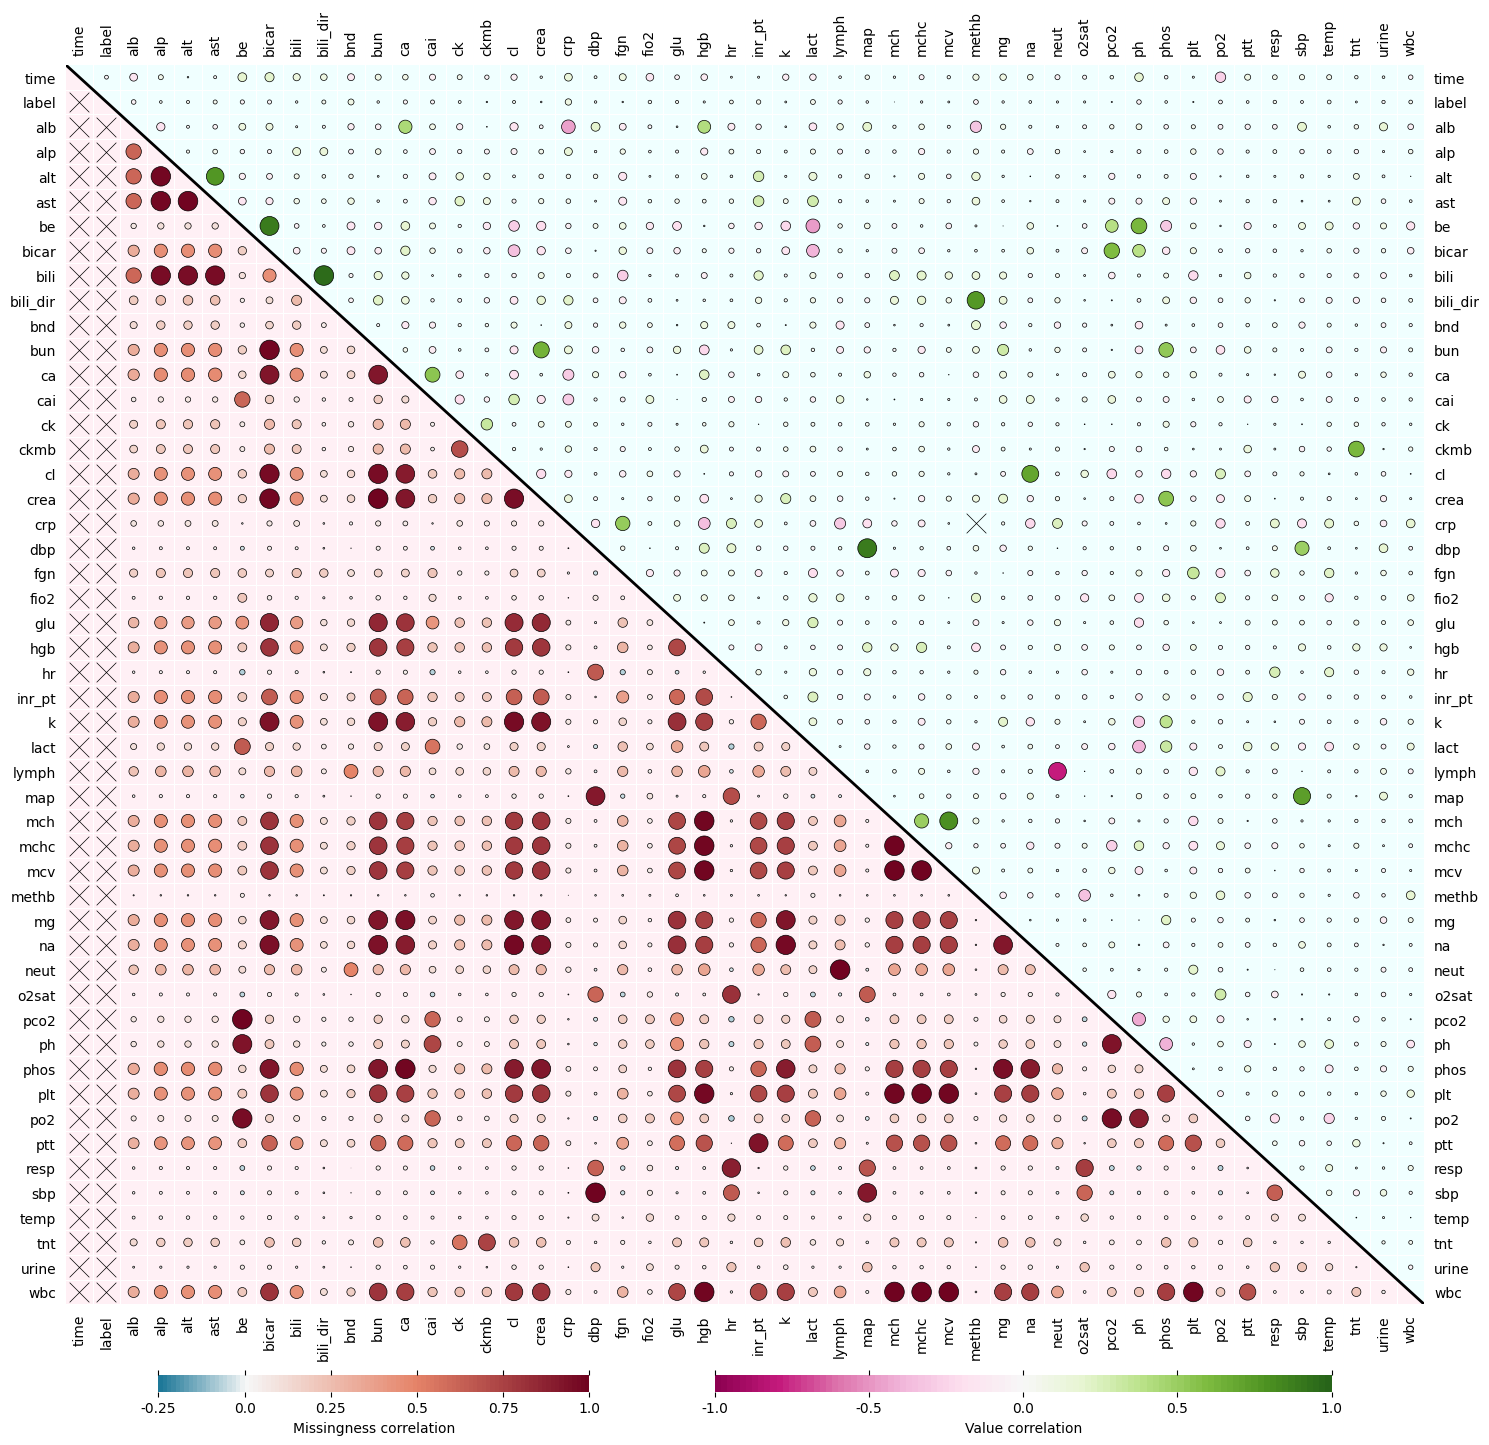

In [81]:
var_slice = slice(1,None) 
corrX = corr.iloc[var_slice, var_slice]
corr_missX = corr_miss.iloc[var_slice, var_slice]
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_all.pdf'
create_correlation_plot(corrX, corr_missX, figsize=(15, 15), path=save_path)

/tmp/ipykernel_3343373/2728010006.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


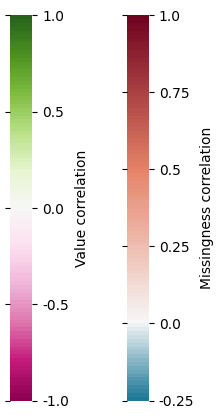

In [77]:
""" Create only the colorbars"""
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_colorbars.pdf'

cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange", 'darkred']) # value colors
cmap1 = 'PiYG'
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, '#1e7898'), (0.2, "#f6f7f7"), (0.6,"#e58368"), (1,'#700320')]) # missingngess colors

fig = plt.figure(figsize=(3, 5))
gs = fig.add_gridspec(100, 40)

ax = fig.add_subplot(gs[:, 8:12])
resolution=100
x = np.linspace(-1,1,resolution)
X = np.repeat(x[:, np.newaxis], 1, axis=1)
ax.pcolormesh(X, cmap=cmap1, vmin=-1, vmax=1)
ax.tick_params(labelbottom=False, labeltop=False, bottom=False, top=False, right=True, labelright=True, labelleft=False, left=True)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Value correlation')
num_ticks = 5
ax.set_yticks(np.linspace(0,1,num_ticks)*resolution*1)
ax.set_yticklabels(np.linspace(-1, 1, num_ticks))
# spines
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)

ax = fig.add_subplot(gs[:, 28:32])
resolution=100
x = np.linspace(-1,1,resolution)
X = np.repeat(x[:, np.newaxis], 1, axis=1)
ax.pcolormesh(X, cmap=cmap2)
ax.tick_params(labelbottom=False, labeltop=False, bottom=False, top=False, right=True, labelright=True, labelleft=False, left=True)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Missingness correlation')
num_ticks = 6
ax.set_yticks(np.linspace(0,1,num_ticks)*resolution*1)
ax.set_yticklabels(np.linspace(-0.25, 1, num_ticks))
# spines
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight', transparent=True, format='pdf')


# Lab tests according to Medical Book

Source: *Laboratory tests and diagnostic procedures, Chernecky et al, 2013*

+ **Complete Blood Count with differential**: hgb rbc hct mcv mch mchc wbc plt rdw lymph neut eos basos
  + ['hct', 'basos', 'eos', 'rbc', 'rdw'] not in index
  + lymph and neut are not super strongly miss correlated with the rest. They are commonly measured for CBC with differential. Maybe the differential is not so common, but if they are measured, then they are measured together.
+ **Complete Blood Count (CBC)**: hgb rbc hct mcv mch mchc wbc plt 
  + ['hct', 'rbc'] not in index
+ **Basic Metabolic Panel (BMP)**: glu bun crea na k cl bicarbonate ca
  + Missing vars bicarbonate
+ **Comprehensive Metabolic Panel (CMP)**: glu bun crea na k cl bicarbonate ca albumin globulin albumin/globulin ratio bilirubin alp ast alt
  + Contains BMP variables and additional ones
  + Missing vars ['bicarbonate', 'albumin/globulin ratio', 'globulin'] not in index
+ **Arterial Blood Gas Panel (ABG):** 'ph', 'pco2', 'po2', 'bicar', 'o2sat'
  + all vars available but it does not seem to be done like this in the lab as well
  


/tmp/ipykernel_3343373/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


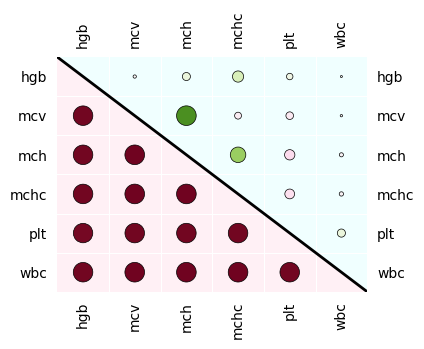

In [36]:
# Complete blood count                       
var_names = ['hgb', 'mcv', 'mch', 'mchc', 'plt', 'wbc']
corr = df[var_names].corr(method='pearson')
df_missingness_indicator = ~df[var_names].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_cbc.pdf'
create_correlation_plot(
    corr[var_names], 
    corr_miss[var_names],
    figsize=(4,4), path=save_path, large=False, colorbars=False)

/tmp/ipykernel_3343373/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


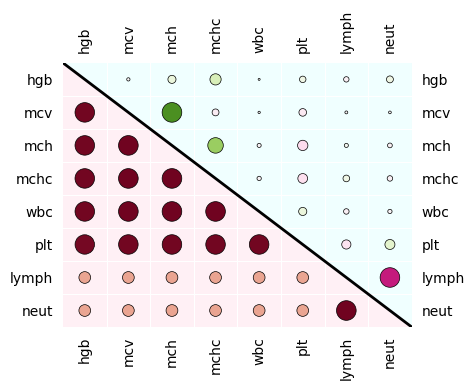

In [37]:
# Differential blood count
var_names = ['hgb', 'mcv', 'mch', 'mchc','wbc','plt','lymph','neut']
corr = df[var_names].corr(method='pearson')
df_missingness_indicator = ~df[var_names].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_cbc_differential.pdf'
create_correlation_plot(
    corr[var_names], 
    corr_miss[var_names],
    figsize=(4.5,4.5), path=save_path, large=False, colorbars=False)

/tmp/ipykernel_3343373/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


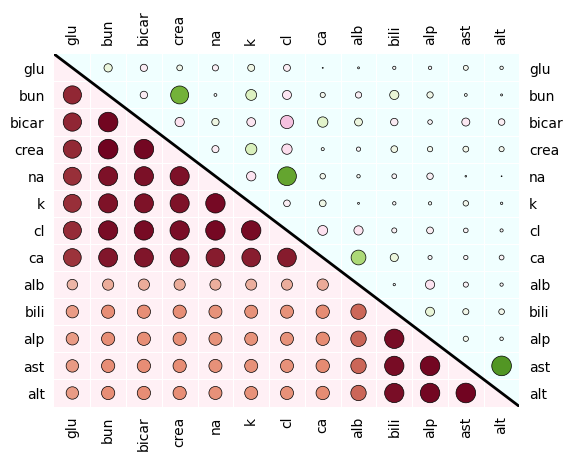

In [31]:
# Comprehensive Metabolic Panel
var_names = ['glu', 'bun', 'bicar', 'crea', 'na', 'k', 'cl', 'ca', 'alb', 'bili', 'alp', 'ast', 'alt']
corr = df[var_names].corr(method='pearson')
df_missingness_indicator = ~df[var_names].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_cmp.pdf'
create_correlation_plot(
    corr[var_names], 
    corr_miss[var_names],
    figsize=(6,6), path=save_path, large=False, colorbars=False)

/tmp/ipykernel_3343373/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


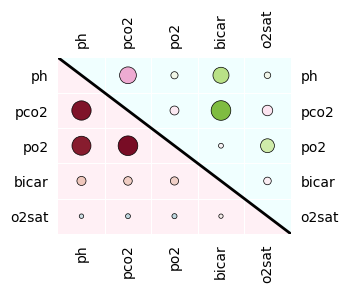

In [35]:
# Arterial Blood Gas Panel
var_names = ['ph', 'pco2', 'po2', 'bicar', 'o2sat']
corr = df[var_names].corr(method='pearson')
df_missingness_indicator = ~df[var_names].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_abg.pdf'
create_correlation_plot(
    corr[var_names], 
    corr_miss[var_names],
    figsize=(3,3), path=save_path, large=False, colorbars=False)

---
## Lab tests according to paper: Deep Reinforcement Learning
> Based off of paper *Deep Reinforcement Learning for Cost-Effective Medical Diagnosis, Yu et al., 2023*.

Now show correlation plots for certain lab tests:
+ **Complete Blood Count Panel**  
  The variable for hematocrit is not explicitly included in the list of variables provided. However, hematocrit is often estimated from the MCV (mean corpuscular volume) and MCH (mean corpuscular hemoglobin) variables, which are included in the list.
  > Note: missing variables red blood cell count (rbc), hematocrit
+ **Arterial Blood Gas Test**
+ **Comprehensive Metabolic Panel**  
  > Note: missing variable total CO2 (tco2)
+ **Activated Partial Thromboplastin Time Test Panel**

> Available variables:   
> ['id', 'time', 'label', 'alb', 'alp', 'alt', 'ast', 'be', 'bicar', 'bili',   
> 'bili_dir', 'bnd', 'bun', 'ca', 'cai', 'ck', 'ckmb', 'cl', 'crea', 'crp',   
> 'dbp', 'fgn', 'fio2', 'glu', 'hgb', 'hr', 'inr_pt', 'k', 'lact', 'lymph',   
> 'map', 'mch', 'mchc', 'mcv', 'methb', 'mg', 'na', 'neut', 'o2sat', 'pco2',   
> 'ph', 'phos', 'plt', 'po2', 'ptt', 'resp', 'sbp', 'temp', 'tnt', 'urine', 'wbc']  
  


In [138]:
# Complete blood count
complete_blood_count = ['hgb', 'mcv', 'mch', 'plt', 'wbc']
corr = df[complete_blood_count].corr(method='pearson')
df_missingness_indicator = ~df[complete_blood_count].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')


/tmp/ipykernel_200152/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


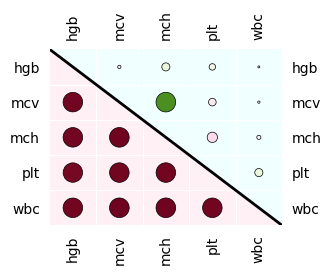

In [147]:
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_blood_panel.pdf'
create_correlation_plot(
    corr[complete_blood_count], 
    corr_miss[complete_blood_count],
    figsize=(3, 3), path=save_path, large=False, colorbars=False)

In [157]:
# Arterial Blood Gas Test
arterial_blood_gas = ['be', 'ph', 'fio2', 'map', 'o2sat']
corr = df[arterial_blood_gas].corr(method='pearson')
df_missingness_indicator = ~df[arterial_blood_gas].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

/tmp/ipykernel_200152/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


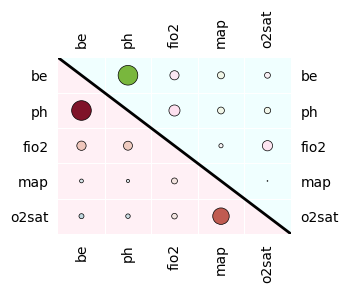

In [158]:
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_arterial_blood_gas.pdf'
create_correlation_plot(
    corr, 
    corr_miss,
    figsize=(3, 3), path=save_path, large=False, colorbars=False)

In [153]:
# Comprehensive Metabolic Panel
# glucose level, bicarbonate level, serum creatinine, aspartate aminotransferase, bilirubin, chloride, carbon dioxide, lactatemagnesuim, urea nitrogen level, albumin, sodium, potassium
metabolic_panel = ['glu', 'bicar', 'crea', 'ast', 'bili', 'cl', 'lact', 'mg', 'bun', 'alb', 'na', 'k']
corr = df[metabolic_panel].corr(method='pearson')
df_missingness_indicator = ~df[metabolic_panel].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')

/tmp/ipykernel_200152/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


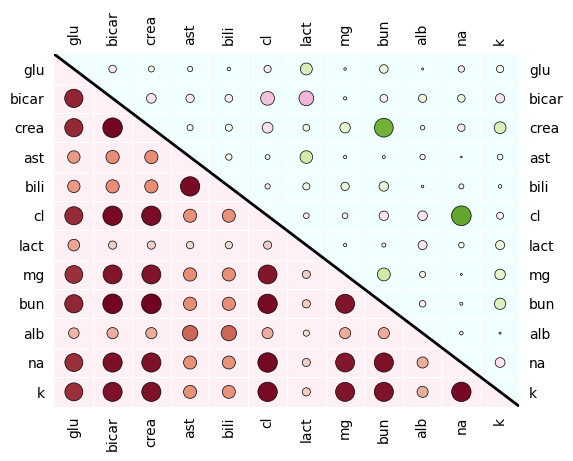

In [156]:
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_metabolic_panel.pdf'
create_correlation_plot(
    corr, 
    corr_miss,
    figsize=(6,6), path=save_path, large=False, colorbars=False)

/tmp/ipykernel_200152/2752465772.py:182: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


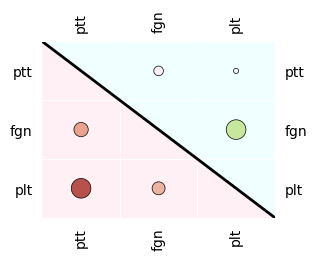

In [160]:
# Activated Partial Thrombo-Plastin Time Test panel
# partial thromboplastin time, fibrinogen, prothrombin time, platelet count
thrombo_panel = ['ptt', 'fgn', 'plt']
corr = df[thrombo_panel].corr(method='pearson')
df_missingness_indicator = ~df[thrombo_panel].isna()*1
corr_miss = df_missingness_indicator.corr(method='pearson')
save_path = '/home2/joshua.wendland/Documents/sepsis/figures/correlation_plot_thrombo_panel.pdf'
create_correlation_plot(
    corr, 
    corr_miss,
    figsize=(3,3), path=save_path, large=False, colorbars=False)

In [125]:
corr.columns

Index(['id', 'time', 'label', 'alb', 'alp', 'alt', 'ast', 'be', 'bicar',
       'bili', 'bili_dir', 'bnd', 'bun', 'ca', 'cai', 'ck', 'ckmb', 'cl',
       'crea', 'crp', 'dbp', 'fgn', 'fio2', 'glu', 'hgb', 'hr', 'inr_pt', 'k',
       'lact', 'lymph', 'map', 'mch', 'mchc', 'mcv', 'methb', 'mg', 'na',
       'neut', 'o2sat', 'pco2', 'ph', 'phos', 'plt', 'po2', 'ptt', 'resp',
       'sbp', 'temp', 'tnt', 'urine', 'wbc'],
      dtype='object')

In [127]:
df.columns

Index(['id', 'time', 'label', 'alb', 'alp', 'alt', 'ast', 'be', 'bicar',
       'bili', 'bili_dir', 'bnd', 'bun', 'ca', 'cai', 'ck', 'ckmb', 'cl',
       'crea', 'crp', 'dbp', 'fgn', 'fio2', 'glu', 'hgb', 'hr', 'inr_pt', 'k',
       'lact', 'lymph', 'map', 'mch', 'mchc', 'mcv', 'methb', 'mg', 'na',
       'neut', 'o2sat', 'pco2', 'ph', 'phos', 'plt', 'po2', 'ptt', 'resp',
       'sbp', 'temp', 'tnt', 'urine', 'wbc'],
      dtype='object')

---

-0.08229578234005915 0.9999838404462719


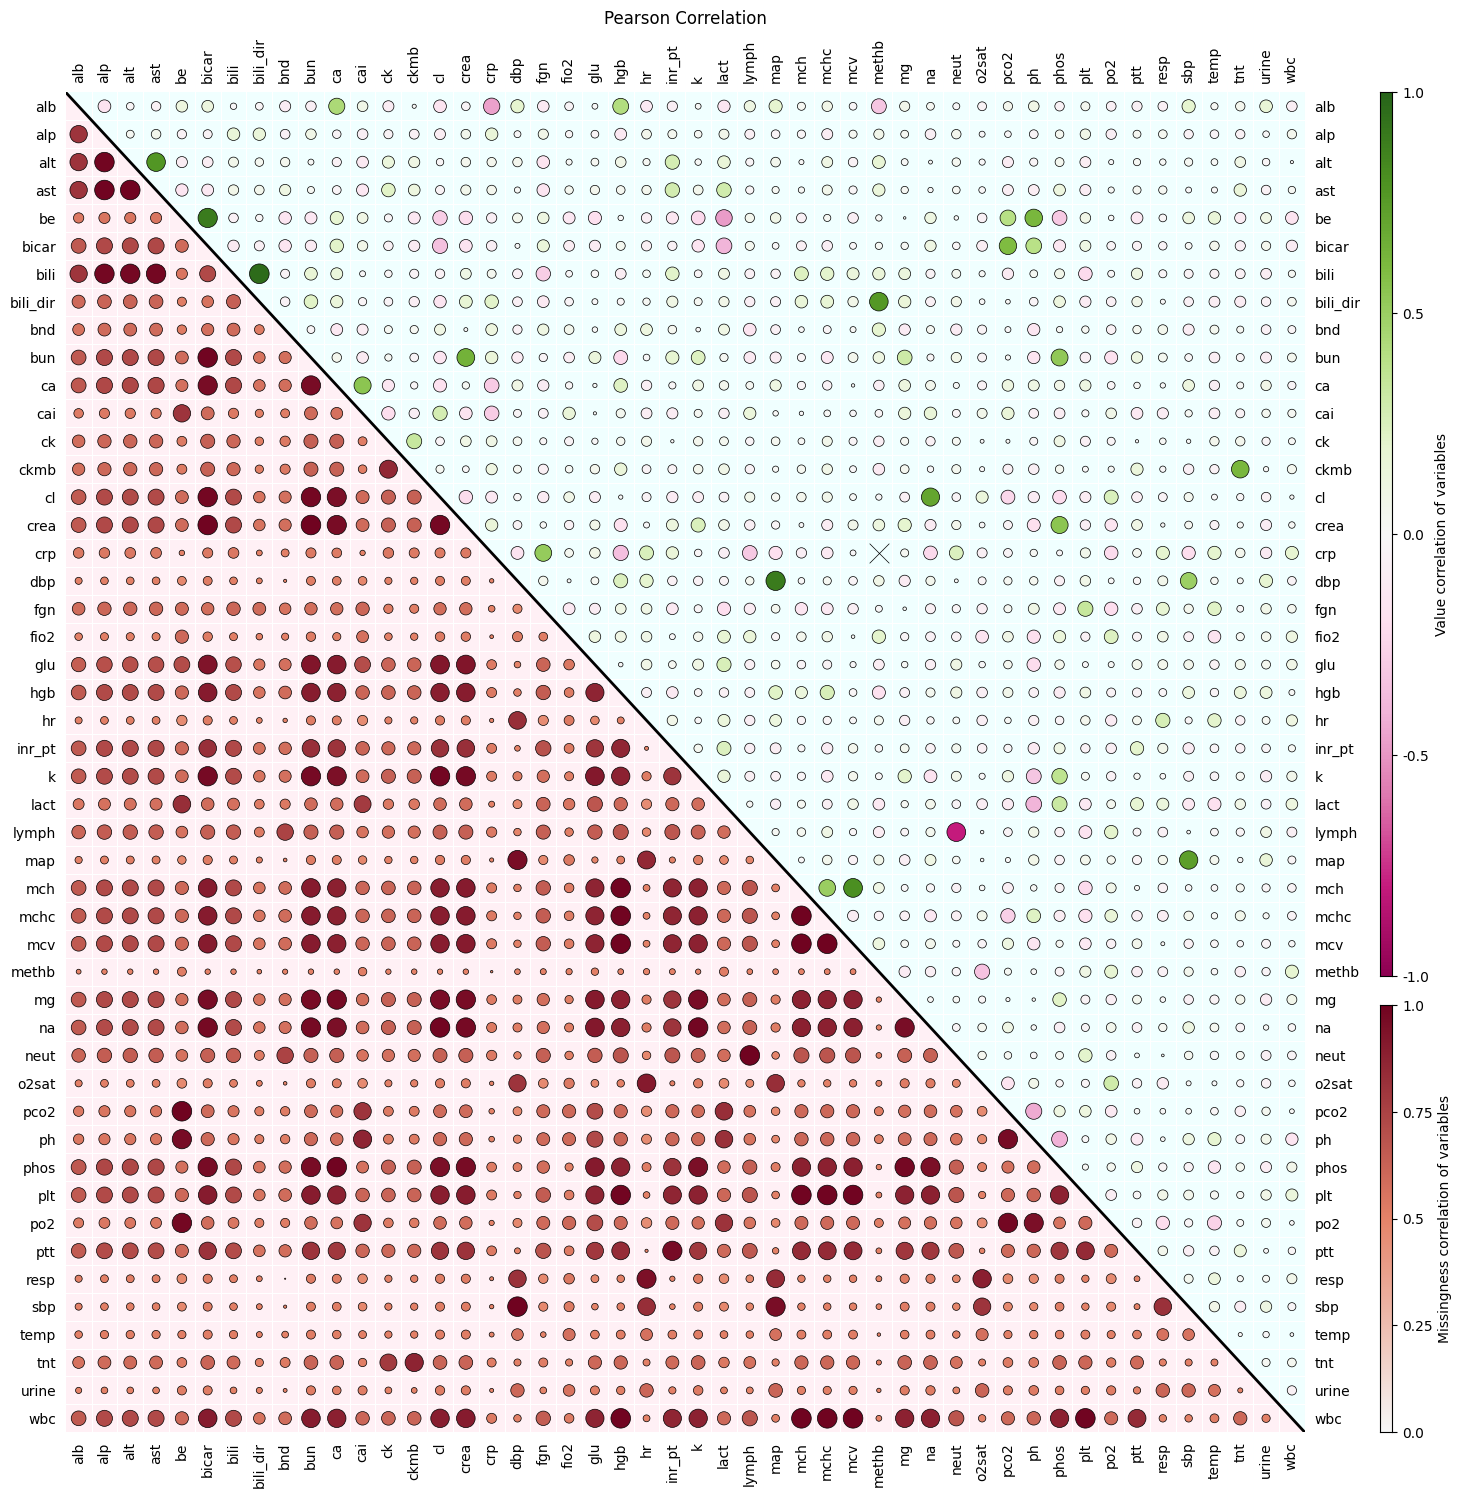

In [5]:
columns = df_missingness_indicator.columns
fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(15, 17)
ax = fig.add_subplot(gs[:,:15])
# ax = plt.gca()

""" ##########     VALUE  CORRELATION   #############"""
plt.title('Pearson Correlation', y=1.045)
corr1 = corr.copy()
corr1[np.tril(corr, k=-1) == 0] = np.nan
# split data into x and y so we can use scatter plot
corr1 = pd.melt(corr1.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr1.columns = ['x', 'y', 'value']
x=corr1['x']
y=corr1['y']
color1 = corr1['value']
size=corr1['value'].abs()
size /= size.max()

# Mapping from column names to integer coordinates
x_labels = [v for v in sorted(x.unique())]
y_labels = [v for v in sorted(y.unique())]
x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
size_scale = 200
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange", 'darkred'])
cmap1 = 'PiYG'
sc1 = ax.scatter(
    x=x.map(x_to_num)+0.5, # Use mapping for x
    y=y.map(y_to_num)+0.5, # Use mapping for y
    s= np.sqrt(size)* size_scale, # Vector of square sizes, proportional to size parameter
    marker='o', # Use square as scatterplot marker
    c=color1, edgecolor='k', linewidth=0.5, cmap=cmap1, vmax=1, vmin=-1,
)

# add crosses, where there is missing data
nan_args = np.argwhere(corr.isna().to_numpy())
nan_args = np.array([(x,y) for (x,y) in list(nan_args) if x>y]) + 0.5
ax.scatter(x=nan_args[:,0], y=nan_args[:,1], marker='x', c='black', s=200, lw=0.5)

""" ##########  MISSINGNESS CORRELATION #############"""
# only show lower triangle
corr2 = corr_miss.copy()
corr2[np.triu(corr2, k=1) == 0] = np.nan

print(corr2.min().min(), corr2.max().max())
# split data into x and y so we can use scatter plot
corr2 = pd.melt(corr2.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr2.columns = ['x', 'y', 'value']
x=corr2['x']
y=corr2['y']
color2 = corr2['value']
size=corr2['value'].abs()
size /= size.max()

# Mapping from column names to integer coordinates
x_labels = [v for v in sorted(x.unique())]
y_labels = [v for v in sorted(y.unique())]
x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
size_scale = 200
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, "#f6f7f7"), (0.5,"#e58368"), (1,'#700320')])
sc2 = ax.scatter(
    x=x.map(x_to_num)+0.5, # Use mapping for x
    y=y.map(y_to_num)+0.5, # Use mapping for y
    s= np.sqrt(size)* size_scale, # Vector of square sizes, proportional to size parameter
    marker='o', # Use square as scatterplot marker
    c=color2, edgecolor='k', linewidth=0.5, cmap=cmap2, vmax=1, vmin=-1,
)


"""  #####  B A C K G R O U N D  &  D E S I G N  ######  """
# diagonal line
points =  [(0, len(columns)), (0, len(columns))]  # ((x1, x2), (y1,y2))
plt.plot(points[0], points[1], color='black', lw=2, ls='-')

# plot polygon (triangle), background color top right
points =  [(0, len(columns), 0), (0, len(columns), len(columns))]  # ((x1, x2, x3), (y1,y2, y3))
Points = np.array([[0,0], [len(columns),len(columns)], [len(columns), 0]])
t1 = plt.Polygon(Points, color='azure', zorder=0)
plt.gca().add_patch(t1)

# background color bottom left
ax.set_facecolor('lavenderblush')

# grid & axis
ax.set_ylim(len(columns), 0)
ax.set_xlim(0, len(columns))
ax.set_xticks(np.arange(0.5, len(columns)))
ax.set_yticks(np.arange(0.5, len(columns)))
ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
ax.set_xticklabels(columns, rotation=90)
ax.set_yticklabels(columns, rotation=00)
ax.tick_params(labelbottom=True, labeltop=True, labelright=True, bottom=True, top=False)
ax.tick_params(which='both', bottom=False, left=False)
ax.grid(False, 'major')
ax.grid(True, 'minor', color='w')

# spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# colorbars in their own subplots
# value correlation
ax = fig.add_subplot(gs[:10,15:16])
resolution=1000
x = np.linspace(-1,1,resolution)
X = np.repeat(x[:, np.newaxis], 100, axis=1)
ax.pcolormesh(X, cmap=cmap1)
ax.tick_params(labelbottom=False, labeltop=False, bottom=False, top=False, right=True, labelright=True, labelleft=False, left=False)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Value correlation of variables')
num_ticks = 5
ax.set_yticks(np.linspace(0,1,num_ticks)*resolution)
ax.set_yticklabels(np.linspace(-1, 1, num_ticks))
# colorbar missingness correlation
ax = fig.add_subplot(gs[10:,15:16])
resolution=1000
x = np.linspace(-1,1,resolution)
X = np.repeat(x[:, np.newaxis], 100, axis=1)
ax.pcolormesh(X, cmap=cmap2)
ax.tick_params(labelbottom=False, labeltop=False, bottom=False, top=False, right=True, labelright=True, labelleft=False, left=False)
ax.yaxis.set_label_position("right")
ax.set_ylabel('Missingness correlation of variables')
num_ticks = 5
ax.set_yticks(np.linspace(0,1,num_ticks)*resolution)
ax.set_yticklabels(np.linspace(0, 1, num_ticks))

plt.tight_layout()
plt.show()

### Analyzing the information we have form the correlation matrix


---

In [ ]:
corr = df.corr()
columns = df.columns
fig = plt.figure(figsize=(15,15))
matshow = plt.matshow(corr, fignum=False, cmap='RdYlGn_r') #xticklabels=corr.columns, yticklabels=corr.columns)

plt.xticks(np.arange(len(columns)), columns, rotation=90)
plt.yticks(np.arange(len(columns)), columns, rotation=00)
# plt.xlim(0, len(columns))
# plt.ylim(0, len(columns))

plt.colorbar(matshow)
plt.title('Pearson Correlation Matrix: Values')

In [7]:
df.to_csv('~/Documents/data/miiv/dyn.csv.gz', compression='infer', index=False)

In [6]:
path = '~/Documents/data/miiv/outc.parquet'
df = pd.read_parquet(path=path)
print(df.shape)
df.tail()

(3552209, 3)


,stay_id,time,label
3552204,39999810,4 days 13:00:00,False
3552205,39999810,4 days 14:00:00,False
3552206,39999810,4 days 15:00:00,False
3552207,39999810,4 days 16:00:00,False
3552208,39999810,4 days 17:00:00,False


(67056, 5)
             id   age     sex  height  weight
67051  39999301  77.0    Male  170.18   107.7
67052  39999384  81.0  Female     NaN    67.0
67053  39999552  72.0  Female  172.72    64.5
67054  39999562  69.0    Male     NaN    62.0
67055  39999810  55.0    Male     NaN    72.0


<Axes: >

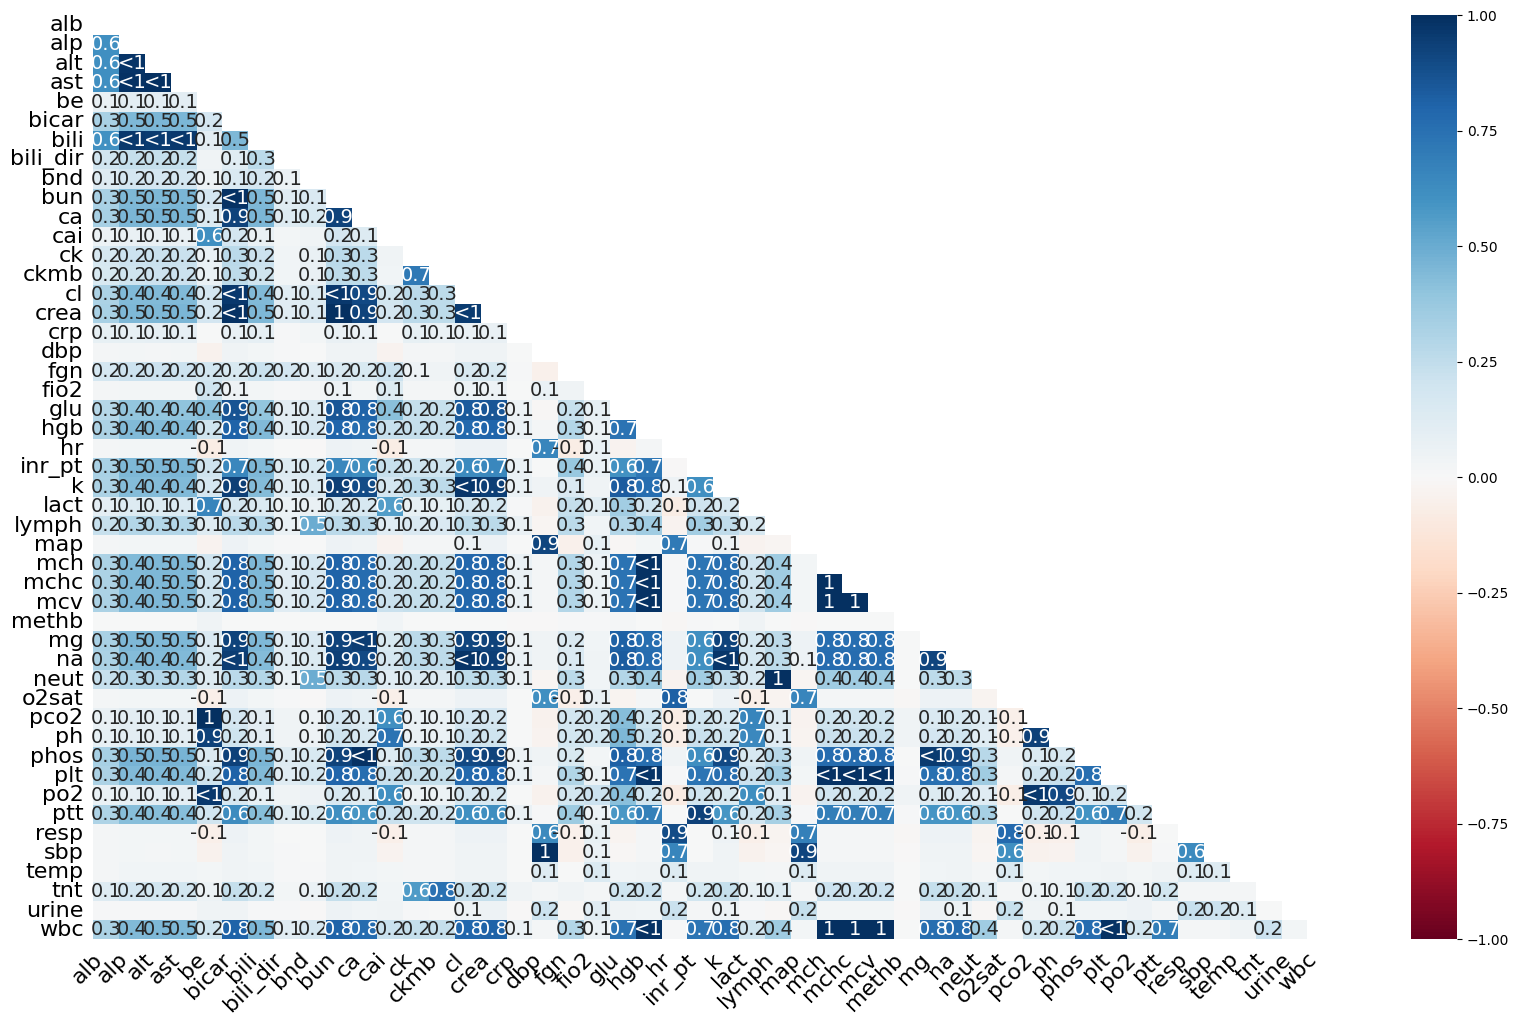

In [15]:
msno.heatmap(df)

In [30]:
# missingno.heatmap(collisions)
mat = msno.matrix(df[df.columns[3:]], labels=True, sparkline=False)
mat.axes[0].tick_params(axis='x', labelsize=30)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

: 

: 

In [16]:
""" COMBINE DYNAMIC AND OUTC DATAFRAMES"""
path_dyn = '~/Documents/data/miiv/dyn.parquet'
path_outc = '~/Documents/data/miiv/outc.parquet'
dyn = pd.read_parquet(path=path_dyn)
dyn = dyn.rename(columns={'stay_id':'id'})
outc = pd.read_parquet(path=path_outc)
outc = outc.rename(columns={'stay_id':'id'})
print(dyn.tail())
print(outc.tail())
combined = pd.merge(outc, dyn, on=['id', 'time'], how='left')
combined.to_parquet('~/Documents/data/miiv/miiv_ts_wide.parquet', index=False)
combined.tail()

               id            time  alb  alp  alt  ast  be  bicar  bili  \
3552204  39999810 4 days 13:00:00  NaN  NaN  NaN  NaN NaN    NaN   NaN   
3552205  39999810 4 days 14:00:00  NaN  NaN  NaN  NaN NaN    NaN   NaN   
3552206  39999810 4 days 15:00:00  NaN  NaN  NaN  NaN NaN    NaN   NaN   
3552207  39999810 4 days 16:00:00  NaN  NaN  NaN  NaN NaN    NaN   NaN   
3552208  39999810 4 days 17:00:00  NaN  NaN  NaN  NaN NaN    NaN   NaN   

         bili_dir  ...  phos  plt  po2  ptt  resp    sbp  temp  tnt  urine  \
3552204       NaN  ...   NaN  NaN  NaN  NaN  15.0  140.0   NaN  NaN    NaN   
3552205       NaN  ...   NaN  NaN  NaN  NaN   NaN    NaN   NaN  NaN    NaN   
3552206       NaN  ...   NaN  NaN  NaN  NaN  17.0  128.0   NaN  NaN    NaN   
3552207       NaN  ...   NaN  NaN  NaN  NaN   NaN    NaN  37.0  NaN    NaN   
3552208       NaN  ...   NaN  NaN  NaN  NaN   NaN    NaN   NaN  NaN    NaN   

         wbc  
3552204  NaN  
3552205  NaN  
3552206  NaN  
3552207  NaN  
3552208  Na

,id,time,label,alb,alp,alt,ast,be,bicar,bili,...,phos,plt,po2,ptt,resp,sbp,temp,tnt,urine,wbc
3552204,39999810,4 days 13:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.0,140.0,NaN,NaN,NaN,NaN
3552205,39999810,4 days 14:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3552206,39999810,4 days 15:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,17.0,128.0,NaN,NaN,NaN,NaN
3552207,39999810,4 days 16:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN
3552208,39999810,4 days 17:00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
""" STATIC """
path = '~/Documents/data/ts/miiv/fully_observed/sta.parquet'
df = pd.read_parquet(path=path)
print(df.shape)
# df.drop(columns=df.columns[0])
df = df.rename(columns={'stay_id':'id'})
df['sex'] = (df['sex'] == 'Female') * 1
df.astype({'sex':'int'})
print(df.tail())
# df.to_csv('~/Documents/data/miiv/miiv_static.csv.gz', compression='infer', index=False)
df.to_parquet('~/Documents/data/ts/miiv/fully_observed/miiv_static.parquet', index=False)

(67056, 5)
             id   age  sex  height  weight
67051  39999301  77.0    0  170.18   107.7
67052  39999384  81.0    0     NaN    67.0
67053  39999552  72.0    0  172.72    64.5
67054  39999562  69.0    0     NaN    62.0
67055  39999810  55.0    0     NaN    72.0


/home2/joshua.wendland/Documents/icuDG/clinicaldg/lib/python3.8/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


NumElements: 2500, Elements in list: 1225


/home2/joshua.wendland/Documents/icuDG/clinicaldg/lib/python3.8/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


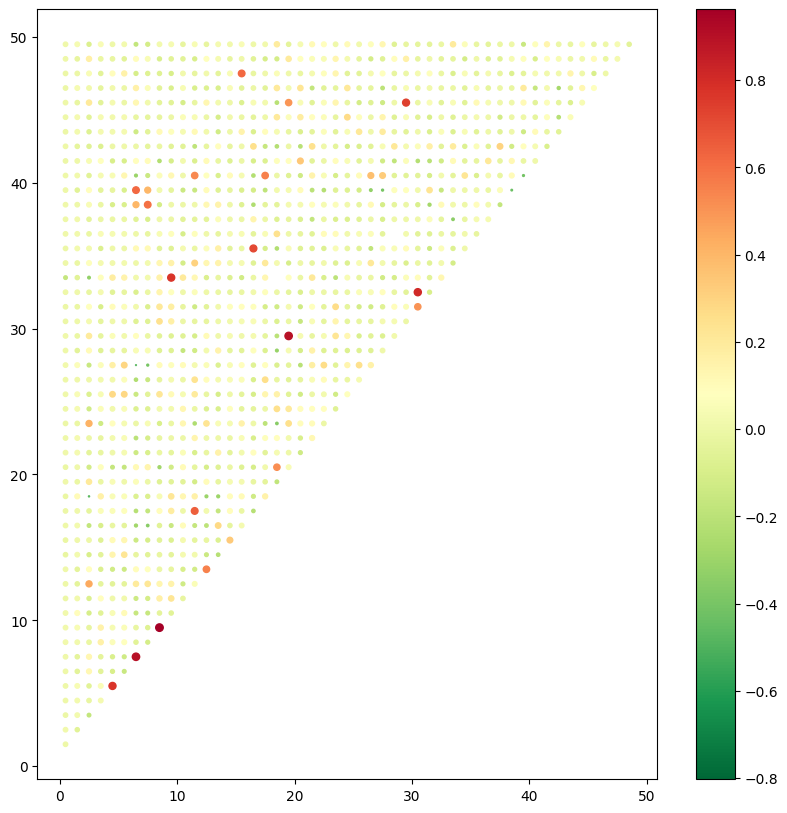

In [109]:
# correlation matrix
corr
I, J  = corr.shape
l = [(i, j, corr.iloc[i,j]) for i in range(I) for j in range(J) if j>i]
corr_list_numpy = np.array(l)   # Shape: num_correlations x (i, j, corr)

print(f'NumElements: {I*J}, Elements in list: {len(l)}')

fig = plt.figure(figsize=(10,10))
plt.scatter(corr_list_numpy[:,0] + 0.5, corr_list_numpy[:,1] + 0.5, c=corr_list_numpy[:,2], cmap='RdYlGn_r', s=corr_list_numpy[:,2]*20+10)
plt.colorbar()

In [163]:
df.dtypes

id                    int32
time        timedelta64[ns]
label                  bool
alb                 float64
alp                 float64
alt                 float64
ast                 float64
be                  float64
bicar               float64
bili                float64
bili_dir            float64
bnd                 float64
bun                 float64
ca                  float64
cai                 float64
ck                  float64
ckmb                float64
cl                  float64
crea                float64
crp                 float64
dbp                 float64
fgn                 float64
fio2                float64
glu                 float64
hgb                 float64
hr                  float64
inr_pt              float64
k                   float64
lact                float64
lymph               float64
map                 float64
mch                 float64
mchc                float64
mcv                 float64
methb               float64
mg                  

In [165]:
df['time'].apply(lambda x: x.total_seconds() / (60*60))

0            0.0
1            1.0
2            2.0
3            3.0
4            4.0
           ...  
3552204    109.0
3552205    110.0
3552206    111.0
3552207    112.0
3552208    113.0
Name: time, Length: 3552209, dtype: float64